In [10]:
from __future__ import print_function
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from matplotlib.patches import Rectangle
from scipy.stats import linregress
import matplotlib.patches as patches
from matplotlib.lines import Line2D

# Add your name below

In [11]:
# hugo h

# Downward camera examples

This notebook contains several images taken from the downward camera on the drone, some of which observe the LED rope, others which do not, and even a couple of examples with one of the obstacles partially blocking the view of the LED rope.

In [12]:
downward = glob.glob("downward/*.jpg")
downward.sort()
downward = [cv2.imread(s, cv2.IMREAD_GRAYSCALE) for s in downward]
print( "{} downward images in dataset".format(len(downward)))

16 downward images in dataset


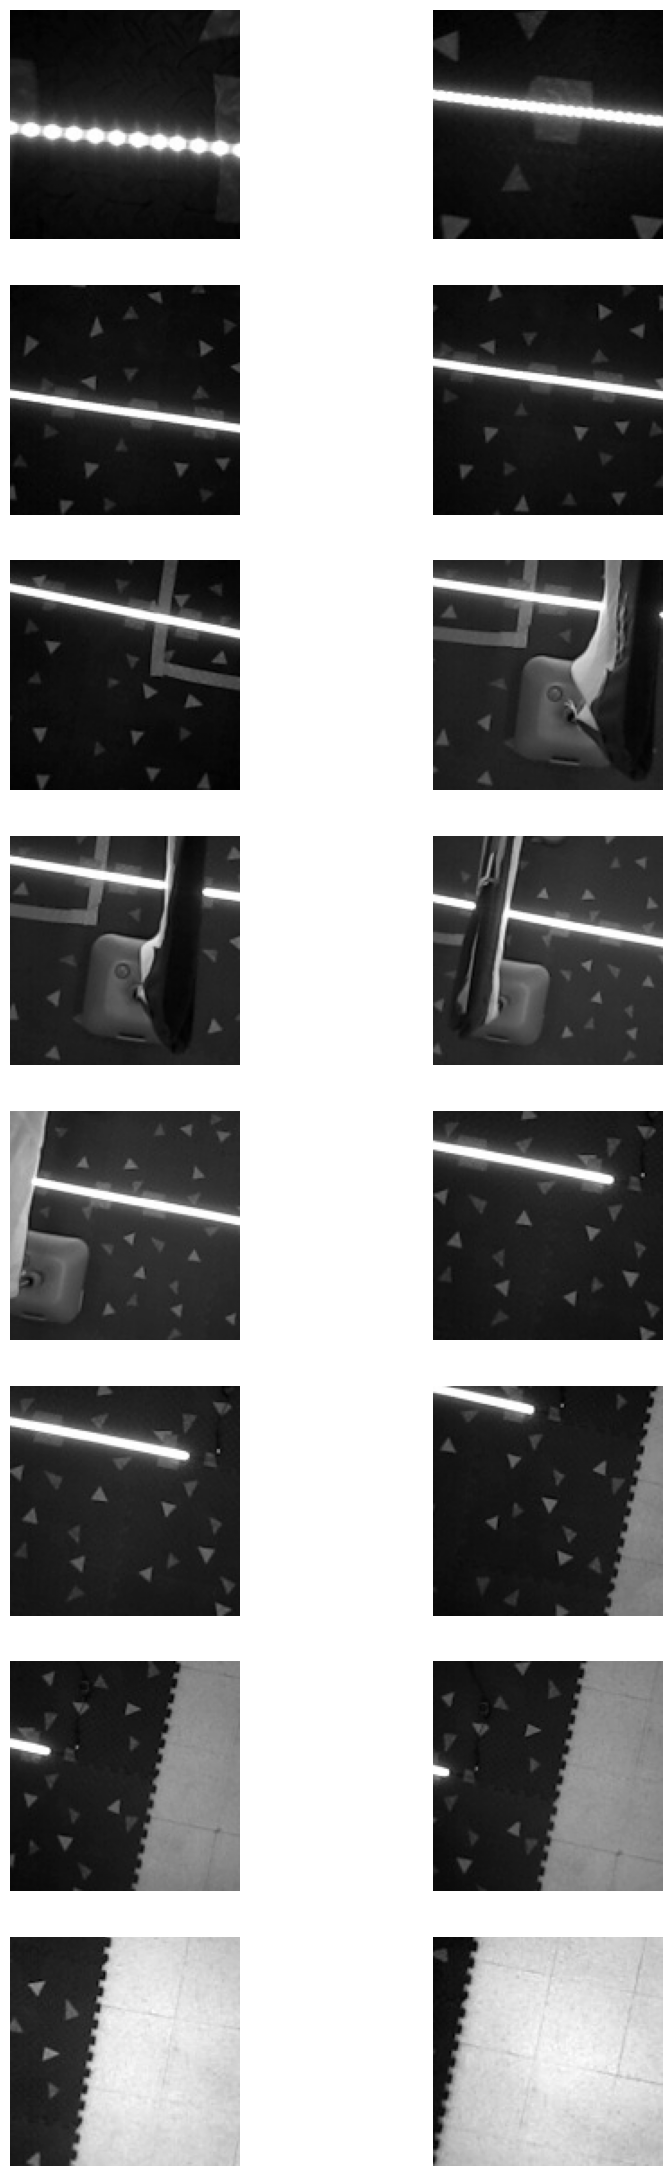

In [13]:
fig, ax = plt.subplots(ncols=2, nrows=len(downward)//2)
[a.axis('off') for a in ax.flatten()]

for d,a in zip(downward, ax.flatten()):
    a.imshow(d, cmap='gray')

fig.set_size_inches(10,28);

# Image Analysis: moving beyond linear regression

## Contour Analysis

You will have to implement more image processing routines beyond linear regression in order to handle several edge cases onboard the drone.

Consider a reflection (from the ceiling lights or the sun) which causes a bright spot in the image at a different position from the LED rope:

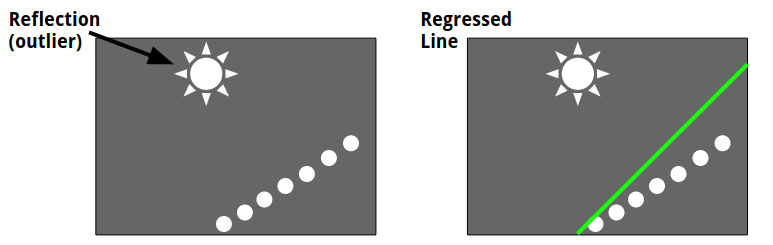

This condition represents an **outlier** - the regressed line will be "pulled" in the direction of the outlier, and not sit directly on the LED rope. One remedy for designing an outlier-robust line detector is to apply some *image morphology* plus *contour analysis.*

For instance, you can use **dilation** in order to connect the individual LED bulbs together into a single contour, and then regress a line through the largest contour found.

# Contour Analysis in OpenCV

The first two tutorials are very helpful to read through for completing this lab exercise (and the rest of the tutorials on contour analysis are linked below, and also worth reading for future reference in the course).

1. https://docs.opencv.org/3.3.1/d4/d73/tutorial_py_contours_begin.html
1. https://docs.opencv.org/3.3.1/dd/d49/tutorial_py_contour_features.html
1. https://docs.opencv.org/3.3.1/d3/d05/tutorial_py_table_of_contents_contours.html

Another example where contour analysis can help is deciding whether or not enough of the line is **visibile** in order to correctly compute a direction in which to fly the drone. Consider the two examples below. Arguably, not enough of the line is visible in the second example to correctly compute a flight direction. (In fact, you might instead want to ensure the line stretches across the entire image, and if not, hover the drone in place.)

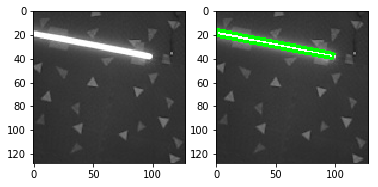

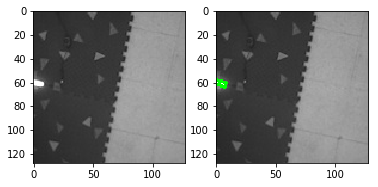

Furthermore, note that applying linear regression on an individal contour is not a panacea to outliers, and indeed, it can lead to undesirable results. In the example below, there is an obstacle sitting above the LED rope. Thus, the largest contour found will not contain the entire LED rope. 

You might thus want to use contour analysis to determine that yes, enough of the LED rope is visible to compute a valid velocity command for the drone (by inspecting the width and height of the contour), but then perform linear regression on the entire (thresholded) image, rather than only on the largest contour found. Alternatively, you might want to consider multiple contours. There are many strategies available to choose from. This is part of the design exercise that your team will proceed through.

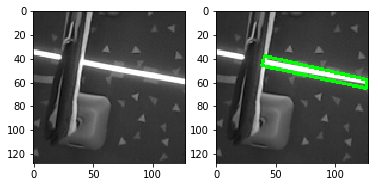

# Morphology

As a final example of "contour analysis gone wrong," observe that the largest contour found in the below image does not contain the entire LED rope - it only contains a couple of individual LED bulbs. This is a case in which **dilation, erosion, opening** or other morphological operations can greatly benefit your image processing pipeline, e.g., by "closing the gaps" between each LED bulb.

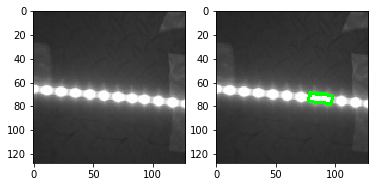

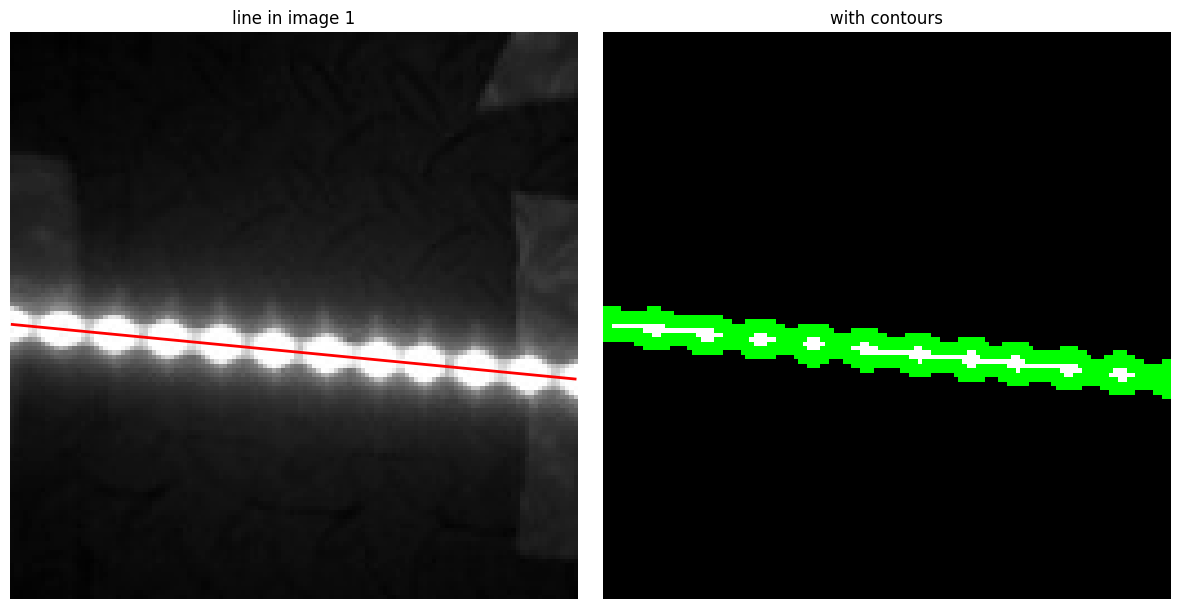

[True]


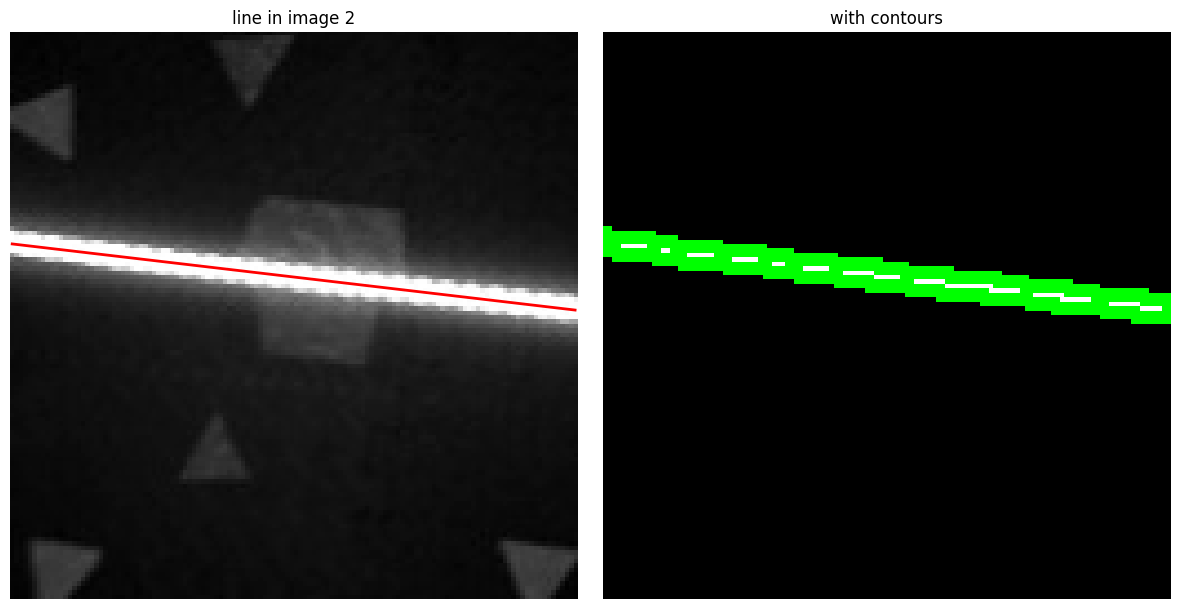

[True, True]


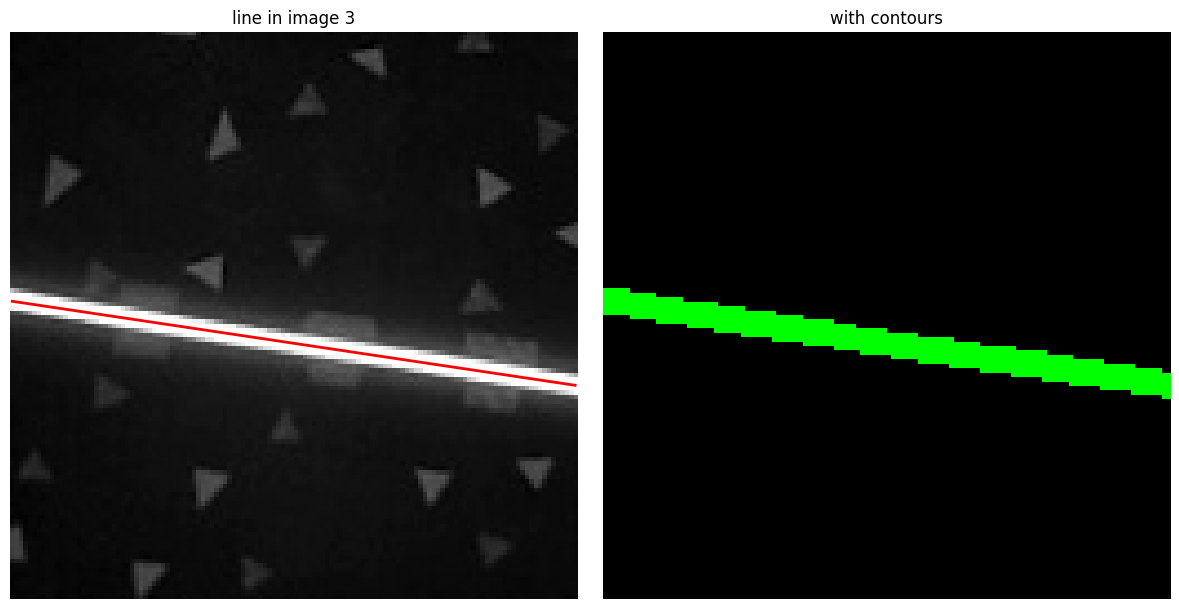

[True, True, True]


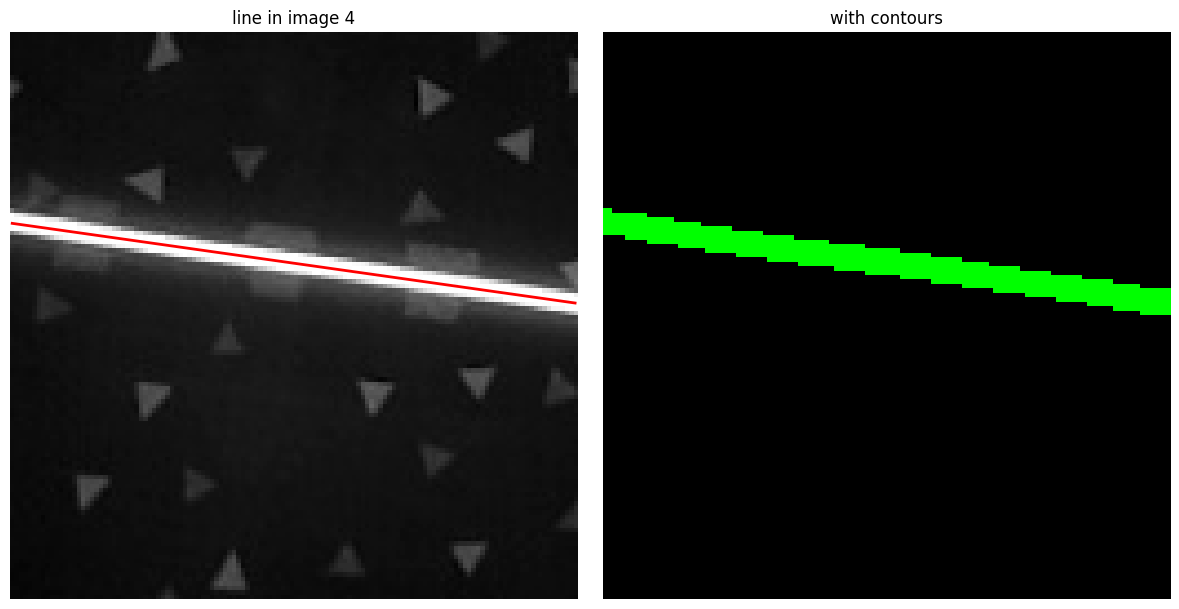

[True, True, True, True]


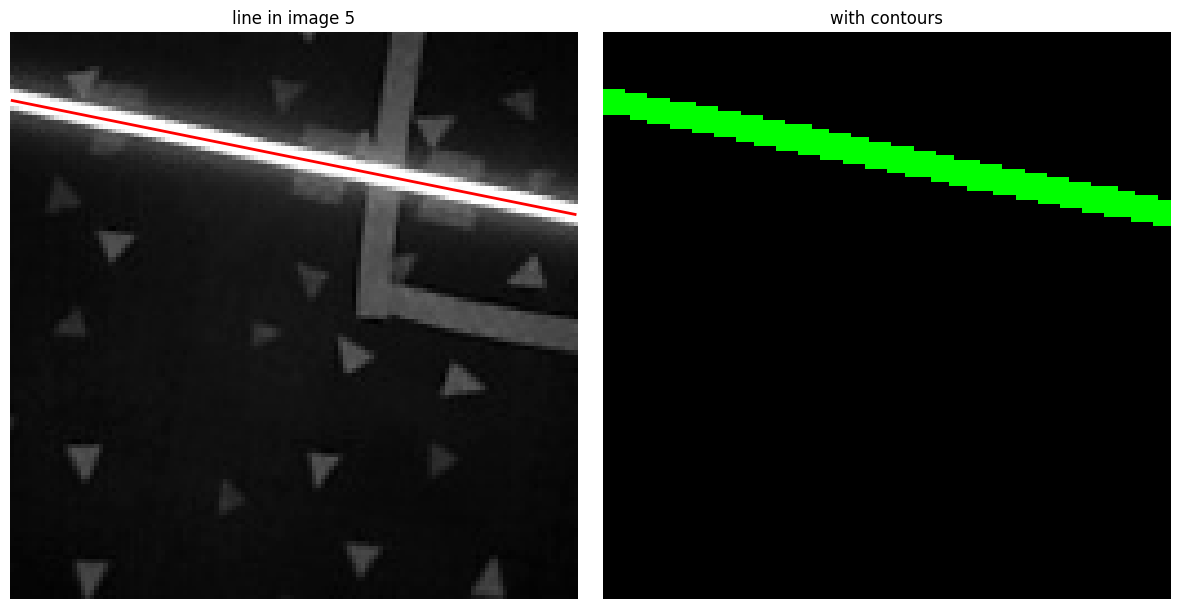

[True, True, True, True, True]


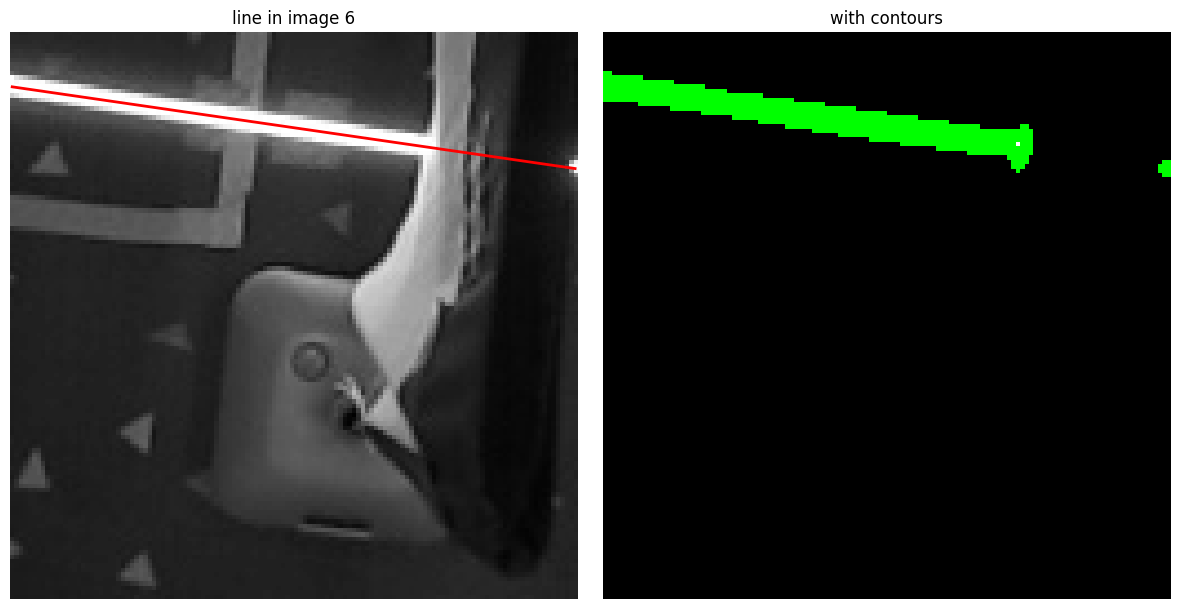

[True, True, True, True, True, True]


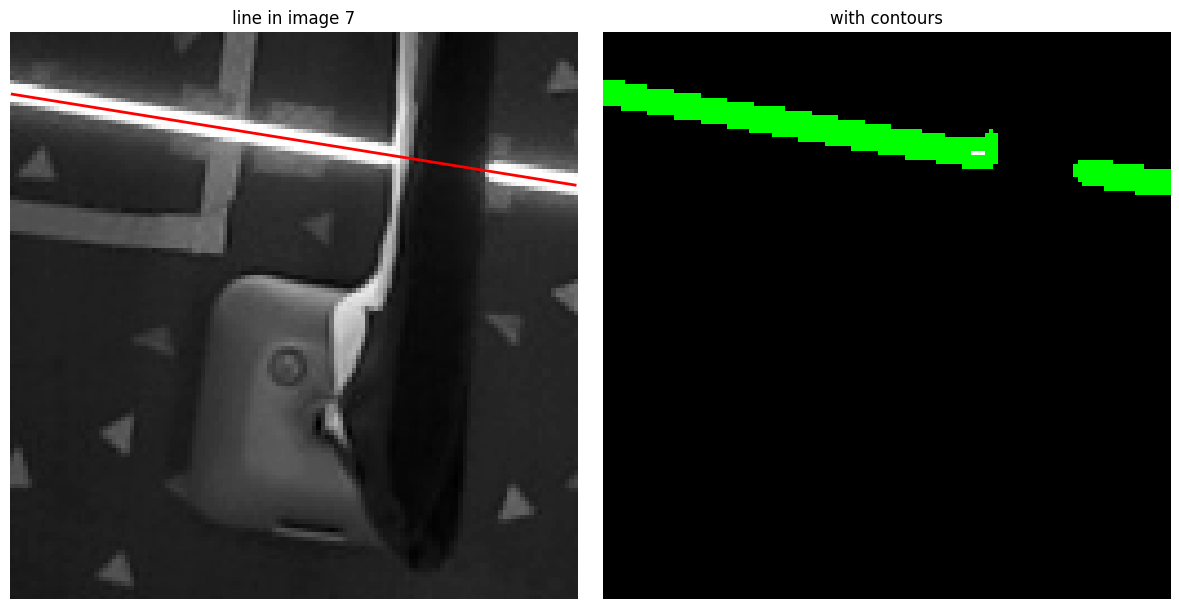

[True, True, True, True, True, True, True]


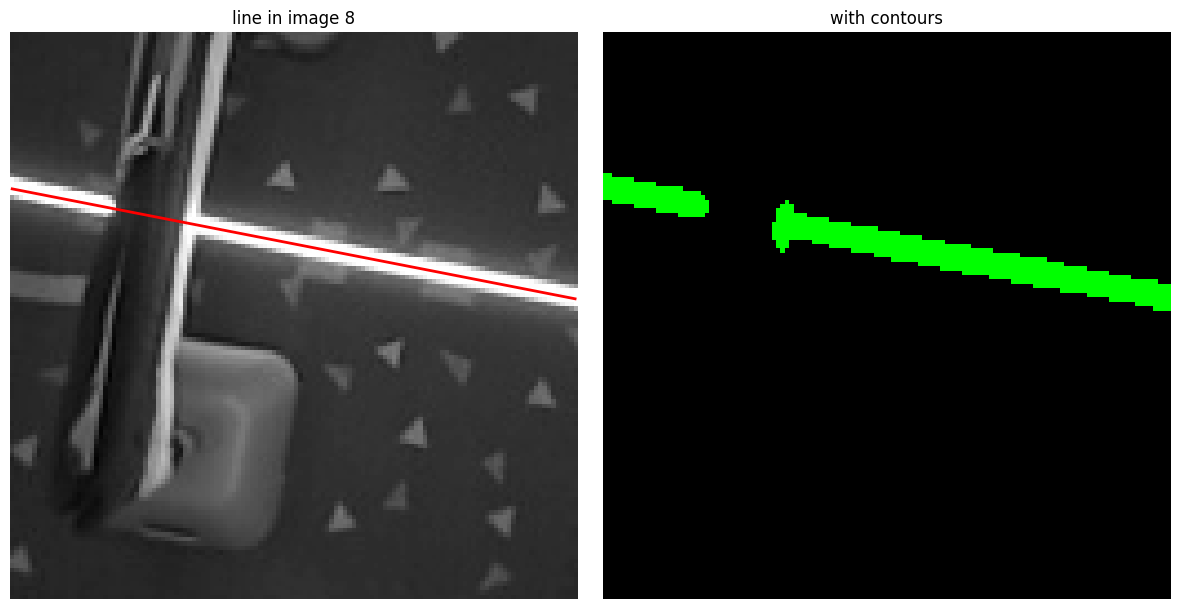

[True, True, True, True, True, True, True, True]


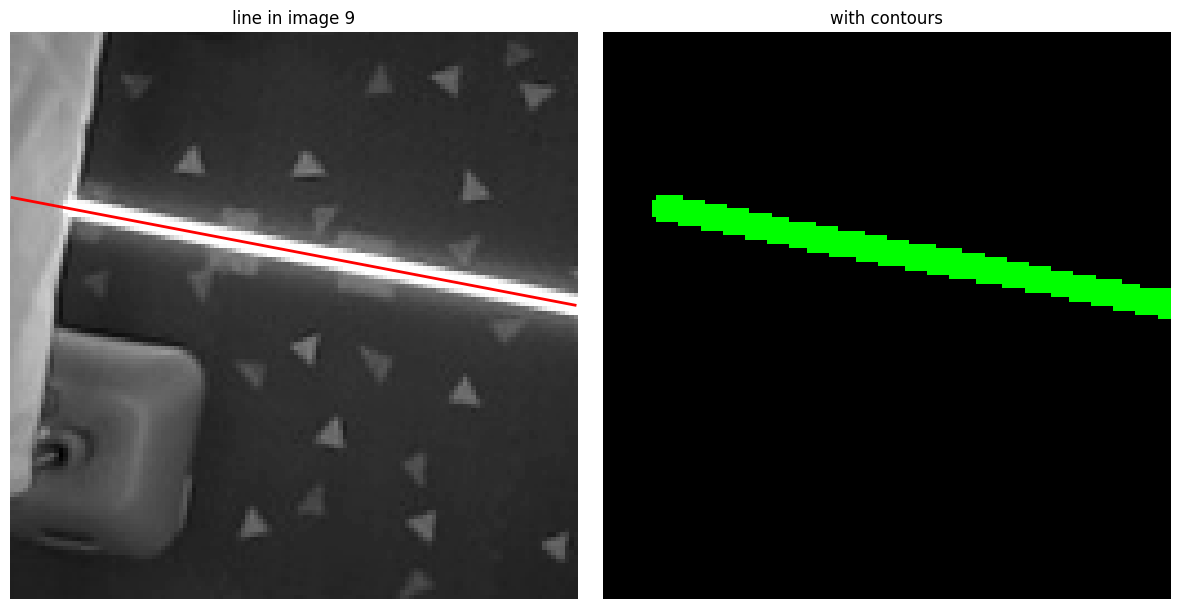

[True, True, True, True, True, True, True, True, True]


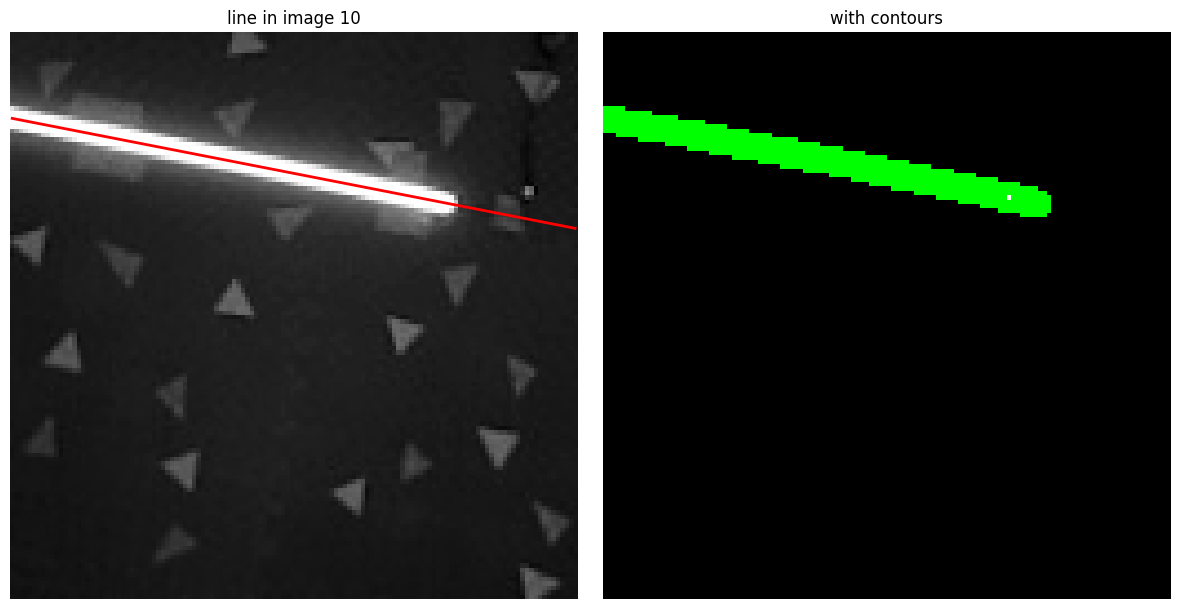

[True, True, True, True, True, True, True, True, True, True]


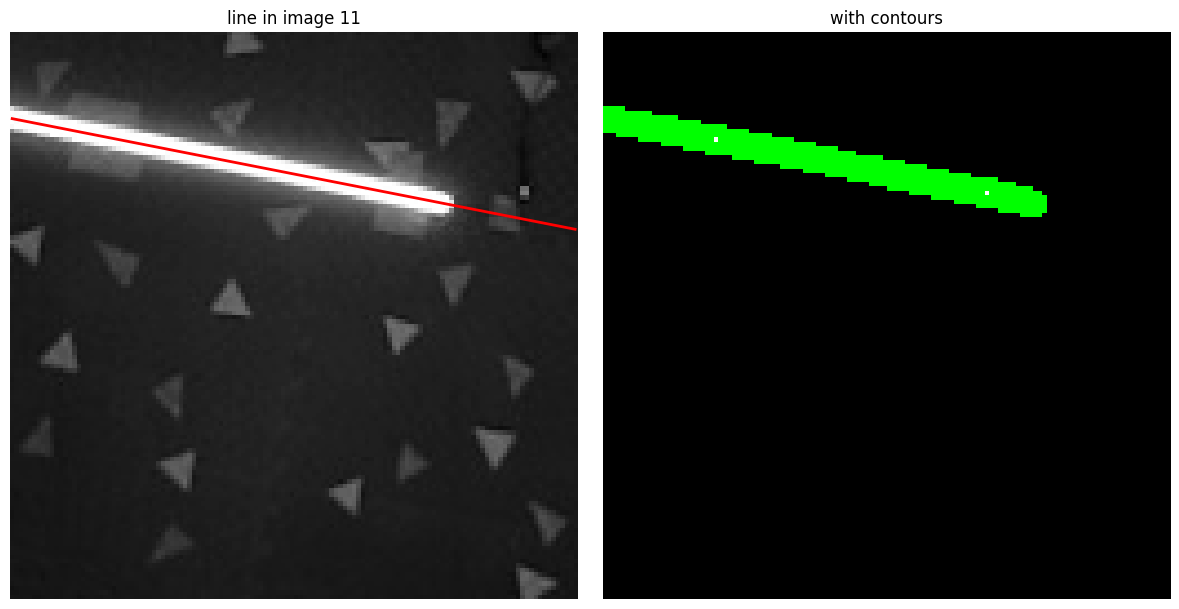

[True, True, True, True, True, True, True, True, True, True, True]


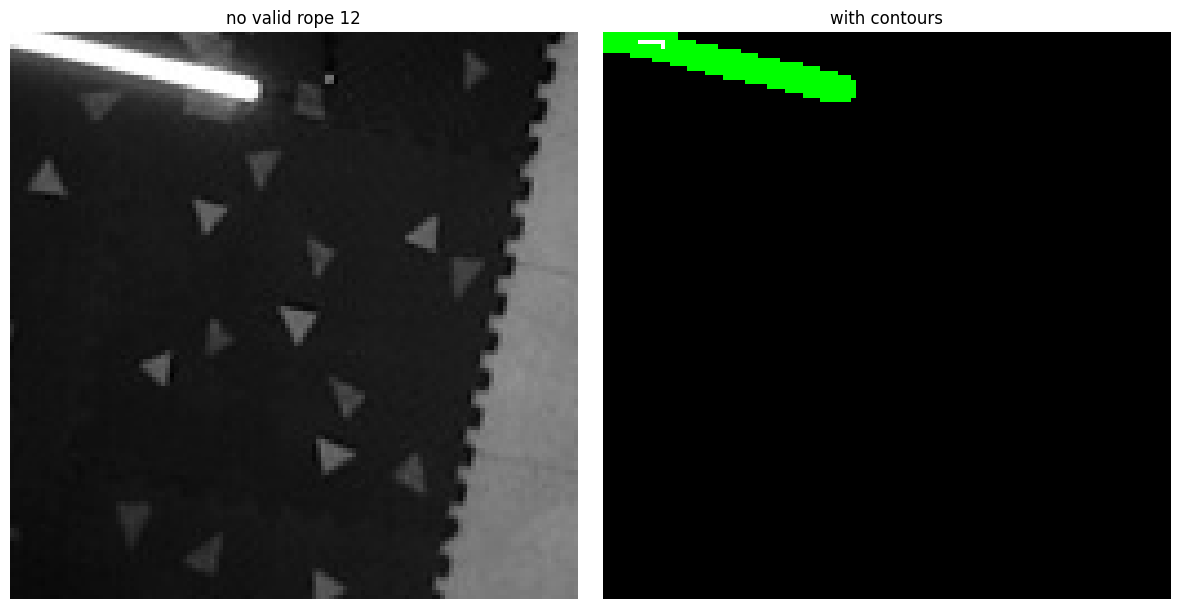

[True, True, True, True, True, True, True, True, True, True, True, False]


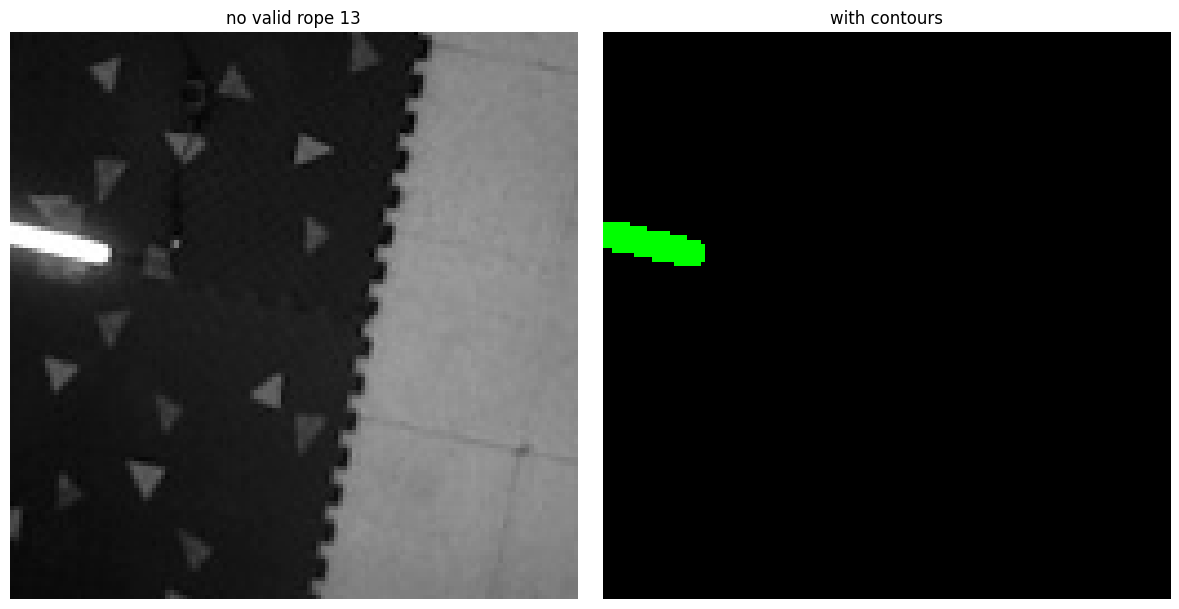

[True, True, True, True, True, True, True, True, True, True, True, False, False]


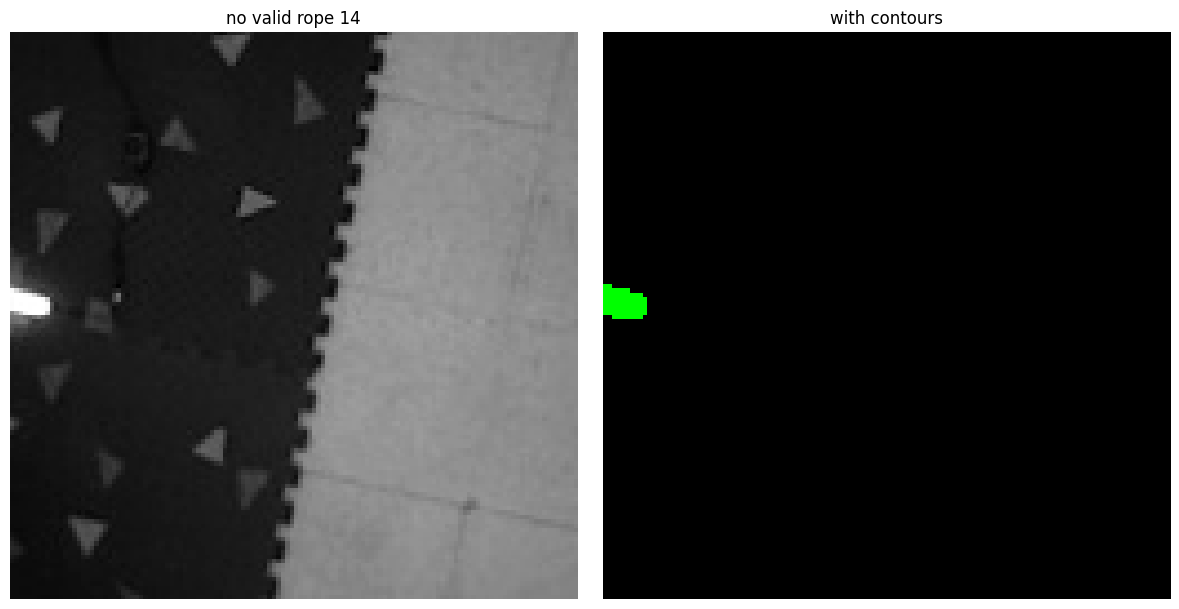

[True, True, True, True, True, True, True, True, True, True, True, False, False, False]


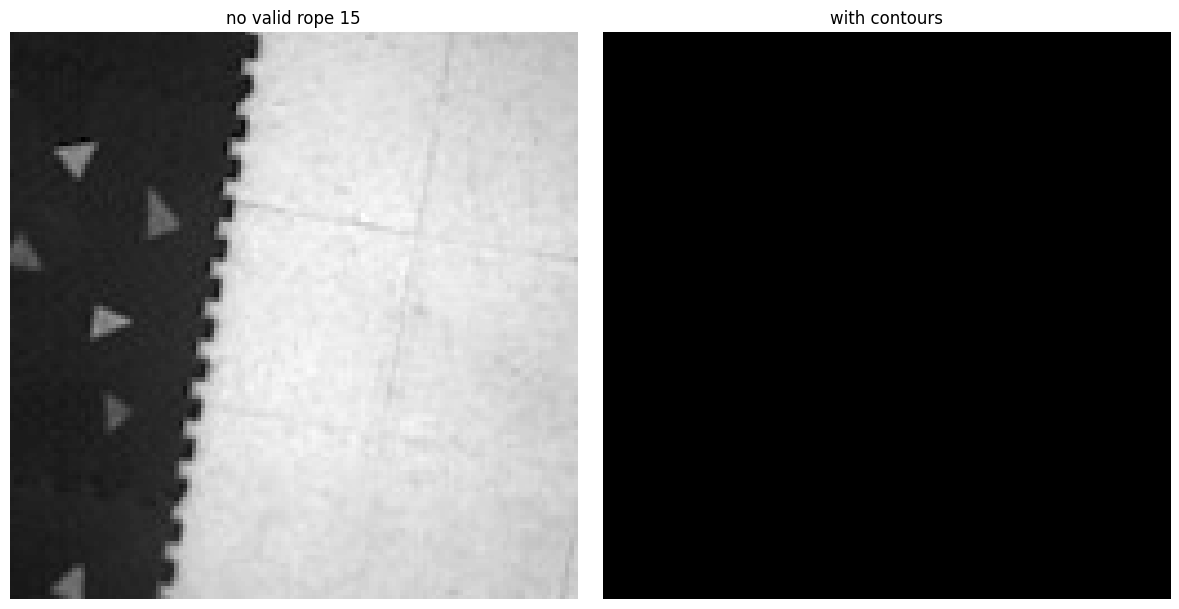

[True, True, True, True, True, True, True, True, True, True, True, False, False, False, False]


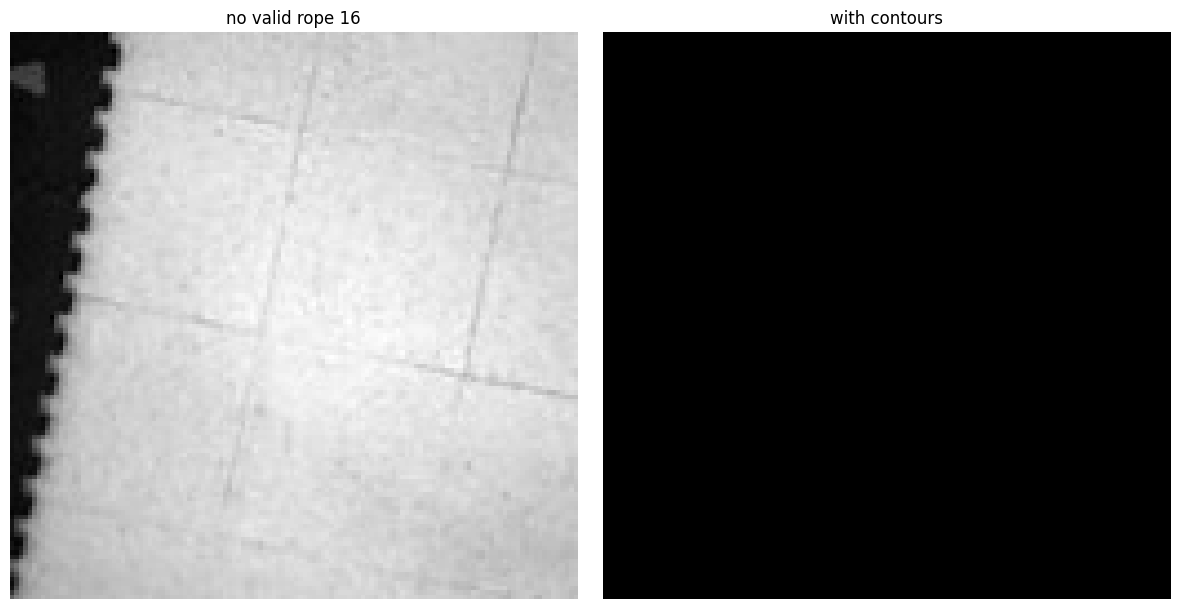

[True, True, True, True, True, True, True, True, True, True, True, False, False, False, False, False]


In [5]:
from __future__ import print_function
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from matplotlib.patches import Rectangle
from scipy.stats import linregress
import matplotlib.patches as patches
from matplotlib.lines import Line2D

results = []
downward = glob.glob("downward/*.jpg")
downward.sort()
downward = [cv2.imread(s, cv2.IMREAD_GRAYSCALE) for s in downward]
images = downward

for i, img in enumerate(images):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title(f'Original Image {i+1}')
    ax[0].axis('off')
    _, thresh = cv2.threshold(img, 240, 255, cv2.THRESH_BINARY)
    kernel = np.ones((5,5), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    line_valid = False
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        area = cv2.contourArea(largest_contour)
        x, y, w, h = cv2.boundingRect(largest_contour)
        min_area, min_dimension, max_aspect_ratio = 200, 50, 10
        if (area > min_area and (w > min_dimension or h > min_dimension) and max(w/h if h > 0 else float('inf'), h/w if w > 0 else float('inf')) < max_aspect_ratio):
            line_valid = True
    ax[1].imshow(thresh, cmap='gray')
    ax[1].set_title('with contours')
    ax[1].axis('off')

    thresh_rgb = cv2.cvtColor(thresh, cv2.COLOR_GRAY2RGB)
    cv2.drawContours(thresh_rgb, contours, -1, (0, 255, 0), 2)
    ax[1].imshow(thresh_rgb)
    if line_valid:
        points = np.argwhere(thresh > 0)
        if len(points) > 10:
            points = points.astype(np.float64)
            xs = points[:, 1]
            ys = points[:, 0]
            slope, intercept, r_value, p_value, std_err = linregress(xs, ys)
            h, w = img.shape
            x1, y1 = 0, intercept
            x2, y2 = w-1, slope * (w - 1) + intercept
            y1 = max(0, min(h-1, y1))
            y2 = max(0, min(h-1, y2))

            line = Line2D([x1, x2], [y1, y2], color='red', linewidth=2)
            ax[0].add_line(line)
            ax[0].set_title(f'line in image {i+1}')
        else:
            ax[0].set_title(f'no valid line in image {i+1}')
    else:
        ax[0].set_title(f'no valid rope {i+1}')
    plt.tight_layout()
    plt.show()

    results.append(line_valid)
    print(results)
    




# Your task

Process all of the images in this small dataset. For each image, write code to detect whether it contains enough of the line to justify further processing (or no line at all), and if your algorithm decides it does contain a sufficient enough portion of the LED rope, plot the regressed line on top of the image. 

Using contour analysis for this task is certainly not required (there are many ways you could tackle this problem), but it's a good place to start!

Note that you may need to tune your thresholding algorithm. Several images in the dataset also contain gray floor tiles, which should *not* be detect as white LED pixels.

# Stretch goals:

You now have implemented linear regression on your own. Compare your answers on all of the above images with two "off-the-shelf" python functions (one from OpenCV, another from scipy) which implement linear regression. Visualize the outputs of both functions, alongside your own implementation from the Linear Regression notebook.

**OpenCV:**

```python
cv2.fitLine()
```

**Scipy:**

```python
from scipy.stats import linregress
```

## When you are done

You should have all sixteen images processed, some with regression lines plotted on top of them, others detected as not containing a line (or not containing enough of the line).

1. Double-check that you filled in your name at the top of the notebook!
2. Click `File` -> `Export Notebook As` -> `PDF`
3. Email the PDF to `YOURTEAMNAME@beaver.works` 